<a href="https://colab.research.google.com/github/hck717/Ichimoku-Fibonacci-Strategy/blob/main/Ichimoku_Fibonacci.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the TA-Lib C library
!apt-get install -y build-essential
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xvzf ta-lib-0.4.0-src.tar.gz
%cd ta-lib-0.4.0
!./configure --prefix=/usr
!make
!make install
%cd ..

# Then install the Python wrapper
!pip install ta-lib



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
--2025-10-31 06:37:22--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-10-31 06:37:23--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Reusing existing connection to prdownloads.sourceforge.n

/tmp/ipython-input-2673300001.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("BTC-USD", period="5y", interval="1d")
[*********************100%***********************]  1 of 1 completed


=== Debug Values ===
Latest Close: 109397.0703125
SSA last valid: 117244.029296875
SSB last valid: 116415.1953125

=== Analysis ===
Trend: Bearish
Swing Low: 103598.43, Swing High: 126198.07
Fib Levels: {'0.236': 120864.555125, '0.382': 117565.00759375, '0.5': 114898.25, '0.618': 112231.49240625, '0.786': 108434.75278124999}
Preferred Entry Zone: 117565.01 – 112231.49
Stop: 126198.07


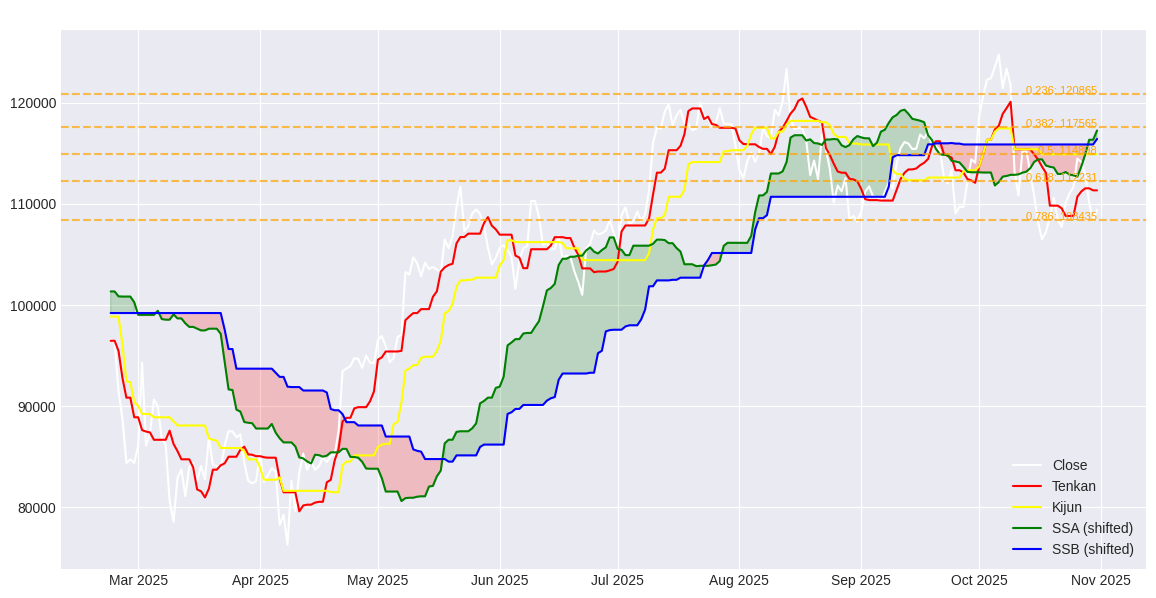

Tenkan head: [           nan            nan            nan            nan
            nan            nan            nan            nan
 14573.29882812 14573.29882812 14573.29882812 14620.85107422
 14942.73779297 15282.63330078 15443.19042969 15443.19042969
 15780.14599609 16324.22460938 16759.45458984 16841.97802734
 17153.99902344 17342.90722656 17342.90722656 17365.07763672
 17614.48876953 17977.75488281 17871.         17871.
 17871.         17871.        ]
Kijun head: [           nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan            nan            nan            nan
            nan 16317.0625     16317.0625     16317.0625
 16358.203125   16485.71826172]
SSA (unshifted) head: [           nan            nan            nan  

In [ ]:
import yfinance as yf
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -----------------------------
# Download 2 years of BTC data (daily)
# -----------------------------
df = yf.download("BTC-USD", period="5y", interval="1d")
df.dropna(inplace=True)

# -----------------------------
# Prepare arrays for TA-Lib (must be 1D float arrays)
# -----------------------------
high = df['High'].astype(float).values.flatten()
low = df['Low'].astype(float).values.flatten()
close = df['Close'].astype(float).values.flatten()

# -----------------------------
# Ichimoku components
# -----------------------------
tenkan = (ta.MAX(high, timeperiod=9) + ta.MIN(low, timeperiod=9)) / 2
kijun = (ta.MAX(high, timeperiod=26) + ta.MIN(low, timeperiod=26)) / 2
ssa = (tenkan + kijun) / 2
ssb = (ta.MAX(high, timeperiod=52) + ta.MIN(low, timeperiod=52)) / 2
chikou = np.concatenate([close[26:], np.full(26, np.nan)])  # lagging span

df['Tenkan'] = tenkan
df['Kijun'] = kijun
# ✅ FIX: align with df.index before shifting
df['SSA'] = pd.Series(ssa, index=df.index).shift(26)
df['SSB'] = pd.Series(ssb, index=df.index).shift(26)
df['Chikou'] = pd.Series(chikou, index=df.index)

# -----------------------------
# Slice to last 1 year for plotting/analysis
# -----------------------------
df_last = df.iloc[-252:]  # ~252 trading days ≈ 1 year

# -----------------------------
# Fibonacci retracement (last 1y swing)
# -----------------------------
swing_low  = lookback_df['Low'].min().item()   # .item() gives scalar
swing_high = lookback_df['High'].max().item()

fib_levels = {
    '0.236': swing_high - (swing_high - swing_low) * 0.236,
    '0.382': swing_high - (swing_high - swing_low) * 0.382,
    '0.5':   swing_high - (swing_high - swing_low) * 0.5,
    '0.618': swing_high - (swing_high - swing_low) * 0.618,
    '0.786': swing_high - (swing_high - swing_low) * 0.786,
}

# -----------------------------
# Trend regime check (use last valid SSA/SSB)
# -----------------------------
latest_close = df_last['Close'].iloc[-1].item()

ssa_series = df['SSA'].dropna()
ssb_series = df['SSB'].dropna()

if not ssa_series.empty and not ssb_series.empty:
    ssa_val = float(ssa_series.iloc[-1])
    ssb_val = float(ssb_series.iloc[-1])
    cloud_top = max(ssa_val, ssb_val)
    cloud_bot = min(ssa_val, ssb_val)

    if latest_close > cloud_top:
        trend = "Bullish"
        entry_zone = (fib_levels['0.382'], fib_levels['0.618'])
        stop = swing_low
    elif latest_close < cloud_bot:
        trend = "Bearish"
        entry_zone = (fib_levels['0.382'], fib_levels['0.618'])
        stop = swing_high
    else:
        trend = "Neutral (inside cloud)"
        entry_zone = None
        stop = None
else:
    trend = "Not enough data for Ichimoku Cloud"
    entry_zone = None
    stop = None

print("=== Debug Values ===")
print("Latest Close:", latest_close)
print("SSA last valid:", ssa_val if not ssa_series.empty else "None")
print("SSB last valid:", ssb_val if not ssb_series.empty else "None")

print("\n=== Analysis ===")
print(f"Trend: {trend}")
print(f"Swing Low: {swing_low:.2f}, Swing High: {swing_high:.2f}")
print("Fib Levels:", fib_levels)
if entry_zone:
    print(f"Preferred Entry Zone: {entry_zone[0]:.2f} – {entry_zone[1]:.2f}")
    print(f"Stop: {stop:.2f}")

# -----------------------------
# Plot chart (last 1 year)
# -----------------------------
plt.style.use("seaborn-v0_8-darkgrid")
fig, ax = plt.subplots(figsize=(14,7))

ax.plot(df_last.index, df_last['Close'], color='white', label='Close')
ax.plot(df_last.index, df_last['Tenkan'], color='red', label='Tenkan')
ax.plot(df_last.index, df_last['Kijun'], color='yellow', label='Kijun')
ax.plot(df_last.index, df_last['SSA'], color='green', label='SSA (shifted)')
ax.plot(df_last.index, df_last['SSB'], color='blue', label='SSB (shifted)')
ax.fill_between(df_last.index, df_last['SSA'], df_last['SSB'],
                where=df_last['SSA']>=df_last['SSB'], color='green', alpha=0.2)
ax.fill_between(df_last.index, df_last['SSA'], df_last['SSB'],
                where=df_last['SSA']<df_last['SSB'], color='red', alpha=0.2)

# Fib levels
for k,v in fib_levels.items():
    ax.axhline(v, linestyle='--', color='orange', alpha=0.7)
    ax.text(df_last.index[-1], v, f"{k}: {v:.0f}", color='orange', fontsize=8, ha='right')

ax.set_title("BTC-USD Ichimoku + Fibonacci (Last 1Y, with 2Y history)", color='white')
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.show()


print("Tenkan head:", tenkan[:30])
print("Kijun head:", kijun[:30])
print("SSA (unshifted) head:", ssa[:30])
print("SSB (unshifted) head:", ssb[:30])

print("Tenkan tail:", tenkan[-30:])
print("Kijun tail:", kijun[-30:])
print("SSA (unshifted) tail:", ssa[-30:])
print("SSB (unshifted) tail:", ssb[-30:])

print("SSA shifted tail:", df['SSA'].tail(30))
print("SSB shifted tail:", df['SSB'].tail(30))




# 📊 How to Read the BTC-USD Ichimoku + Fibonacci Chart

This chart combines **Ichimoku Cloud** analysis with **Fibonacci retracement levels** to help identify trend direction, support/resistance, and potential trade zones.

---

## 🟢 Ichimoku Cloud Components

- **Tenkan-sen (Conversion Line, red)**  
  - Short-term trend (9 periods).  
  - Steeper slope = stronger short-term momentum.

- **Kijun-sen (Base Line, yellow)**  
  - Medium-term trend (26 periods).  
  - Often acts as support/resistance.  
  - Crossovers with Tenkan can signal momentum shifts.

- **Senkou Span A (SSA, green)**  
  - Leading line, average of Tenkan & Kijun, shifted 26 periods forward.  
  - Forms one edge of the cloud.

- **Senkou Span B (SSB, blue)**  
  - Leading line, 52-period high/low midpoint, shifted 26 periods forward.  
  - Forms the other edge of the cloud.

- **Kumo (Cloud fill)**  
  - Green cloud = bullish (SSA above SSB).  
  - Red cloud = bearish (SSA below SSB).  
  - Price **above cloud** = bullish trend.  
  - Price **below cloud** = bearish trend.  
  - Price **inside cloud** = neutral / consolidation.

---

## 🔢 Fibonacci Retracement Levels (orange dashed lines)

- Calculated from the **swing high** and **swing low** of the last year.  
- Key levels: **0.236, 0.382, 0.5, 0.618, 0.786**.  
- These act as potential **support/resistance zones**.  
- Traders often look for entries around **0.382–0.618 retracement**.

---

## 🧭 How to Interpret

1. **Trend Direction**  
   - Price above cloud → bullish bias.  
   - Price below cloud → bearish bias.  
   - Price inside cloud → neutral / indecision.

2. **Entry Zones**  
   - In a bullish trend: look for pullbacks into 0.382–0.618 Fib zone as potential buys.  
   - In a bearish trend: look for rallies into 0.382–0.618 Fib zone as potential shorts.

3. **Stop Placement**  
   - Bullish setups: stop below swing low.  
   - Bearish setups: stop above swing high.

4. **Confluence**  
   - Strong signals occur when **Fib levels align with Ichimoku levels** (Kijun, SSA, SSB).

---

## ⚠️ Notes

- The Ichimoku Cloud is **forward-shifted**, so the last 26 candles may show NaN values in the data but still plot correctly.  
- Always confirm signals with volume, candlestick patterns, or other indicators.  
- This chart is for **educational purposes only**, not financial advice.


Robust strategy

In [ ]:
import yfinance as yf
import talib as ta
import pandas as pd
import numpy as np

SLIPPAGE = 0.001  # 0.1% slippage per trade
TRANSACTION_COST = 0.0005  # 0.05% per trade



# -------------------------------------------------
# Parameters
# -------------------------------------------------
ASSETS = [
    "BTC-USD", "ETH-USD",
    # Approx. top SPY constituents (adjust as needed)
    "AAPL", "MSFT", "AMZN", "NVDA", "GOOGL", "GOOG", "META", "TSLA", "BRK-B", "AVGO"
]
PERIOD_YEARS = 8
INTERVAL = "1d"
LOOKBACK_DAYS = 252            # for swing high/low and regime context
FIB_ZONE = (0.382, 0.618)      # entry zone
FIB_TP1 = 0.236                # first profit target
TIME_STOP_DAYS = 30
ALLOW_SHORTS = True
TRAIL_BY_KIJUN = True

# -------------------------------------------------
# Helpers: metrics, drawdown, VaR/CVaR, safe scalar
# -------------------------------------------------
def safe_scalar(x):
    # Return Python float scalar robustly
    if isinstance(x, (float, int, np.floating, np.integer)):
        return float(x)
    if hasattr(x, "item"):
        return float(x.item())
    return float(x)

def compute_drawdown_nav(nav):
    peak = nav.cummax()
    dd = (nav - peak) / peak
    max_dd = dd.min()
    return dd, max_dd

def annualization_factor(freq="D"):
    # Daily freq assumed here
    return 252

def performance_metrics(equity_curve):
    equity_curve = equity_curve.dropna()
    if equity_curve.empty:
        return {k:0.0 for k in ["CAGR","Sharpe","Sortino","MaxDrawdown","VaR_95","CVaR_95","Volatility","TotalReturn"]}

    returns = equity_curve.pct_change().dropna()
    ann_fac = 252

    # Total return %
    total_return = equity_curve.iloc[-1] / equity_curve.iloc[0] - 1

    # CAGR
    if equity_curve.iloc[0] <= 0 or equity_curve.iloc[-1] <= 0:
        cagr = 0.0
    else:
        years = len(equity_curve) / ann_fac
        cagr = (1 + total_return) ** (1 / years) - 1 if years > 0 else 0.0

    vol = returns.std() * np.sqrt(ann_fac)
    sharpe = (returns.mean() * ann_fac) / vol if vol > 0 else 0.0
    downside = returns[returns < 0]
    ddev = downside.std() * np.sqrt(ann_fac)
    sortino = (returns.mean() * ann_fac) / ddev if ddev > 0 else 0.0

    peak = equity_curve.cummax()
    dd = equity_curve / peak - 1
    max_dd = max(dd.min(), -1.0)

    alpha = 0.95
    var_95 = np.quantile(returns, 1 - alpha) if not returns.empty else 0.0
    cvar_95 = returns[returns <= var_95].mean() if (returns <= var_95).any() else var_95

    return {
        "TotalReturn": float(total_return),
        "CAGR": cagr,
        "Sharpe": sharpe,
        "Sortino": sortino,
        "MaxDrawdown": float(max_dd),
        "VaR_95": float(var_95),
        "CVaR_95": float(cvar_95),
        "Volatility": float(vol)
    }

# -------------------------------------------------
# Ichimoku computation (numpy arrays; then aligned)
# -------------------------------------------------
def ichimoku(df):
    high  = df["High"].to_numpy(dtype="float64").ravel()
    low   = df["Low"].to_numpy(dtype="float64").ravel()
    close = df["Close"].to_numpy(dtype="float64").ravel()

    tenkan = (ta.MAX(high, timeperiod=9) + ta.MIN(low, timeperiod=9)) / 2
    kijun  = (ta.MAX(high, timeperiod=26) + ta.MIN(low, timeperiod=26)) / 2
    ssa    = (tenkan + kijun) / 2
    ssb    = (ta.MAX(high, timeperiod=52) + ta.MIN(low, timeperiod=52)) / 2
    chikou = np.concatenate([close[26:], np.full(26, np.nan)])

    out = pd.DataFrame(index=df.index)
    out["Tenkan"] = tenkan
    out["Kijun"]  = kijun
    out["SSA"]    = pd.Series(ssa, index=df.index).shift(26)
    out["SSB"]    = pd.Series(ssb, index=df.index).shift(26)
    out["Chikou"] = pd.Series(chikou, index=df.index)
    return out

# -------------------------------------------------
# Fibonacci levels from lookback window (fix lookback_df)
# -------------------------------------------------
def fib_levels_from_lookback(lookback_df):
    # Define swing using lookback window highs/lows
    swing_low  = safe_scalar(lookback_df["Low"].min())
    swing_high = safe_scalar(lookback_df["High"].max())
    rng = swing_high - swing_low
    levels = {
        "0.236": swing_high - rng * 0.236,
        "0.382": swing_high - rng * 0.382,
        "0.5":   swing_high - rng * 0.5,
        "0.618": swing_high - rng * 0.618,
        "0.786": swing_high - rng * 0.786,
        "High":  swing_high,
        "Low":   swing_low
    }
    return levels

# -------------------------------------------------
# Entry/exit evaluation per bar
# -------------------------------------------------
def regime_from_cloud(close_val, ssa_val, ssb_val):
    top = max(ssa_val, ssb_val)
    bot = min(ssa_val, ssb_val)
    if close_val > top:
        return "Bullish", top, bot
    elif close_val < bot:
        return "Bearish", top, bot
    else:
        return "Neutral", top, bot

def evaluate_entry(df, i, fib, regime):
    # Enter when price moves into 0.382–0.618 from outside, consistent with regime
    price = safe_scalar(df["Close"].iloc[i])
    prev_price = safe_scalar(df["Close"].iloc[i-1]) if i > 0 else price
    zone_low, zone_high = fib["0.618"], fib["0.382"]  # zone is [0.618, 0.382] descending from High
    if regime == "Bullish":
        # Pullback into zone: previous above 0.382 and now inside [0.618, 0.382]
        if prev_price > fib["0.382"] and zone_low <= price <= zone_high:
            return {"side": "Long", "entry": price}
    if ALLOW_SHORTS and regime == "Bearish":
        if prev_price < fib["0.382"] and zone_low <= price <= zone_high:
            return {"side": "Short", "entry": price}
    return None

def evaluate_exit(trade, df_slice, fib, kijun_series):
    # Returns exit info with partial TP and time stop logic
    side = trade["Side"]
    entry_idx = trade["EntryIndex"]
    entry_px = trade["EntryPrice"]
    stop_px = trade["StopPrice"]
    breakeven = False
    qty = 1.0  # normalized position
    remaining_qty = qty

    tp1_level = fib["0.236"]
    final_target = fib["High"] if side == "Long" else fib["Low"]

    for j, (ts, row) in enumerate(df_slice.iterrows(), start=0):
        price = safe_scalar(row["Close"])
        kijun_val = safe_scalar(kijun_series.loc[ts]) if TRAIL_BY_KIJUN and ts in kijun_series.index else np.nan

        # Stop check
        if side == "Long":
            stop_hit = price < stop_px
        else:
            stop_hit = price > stop_px
        if stop_hit:
            exit_px = price
            holding = j + 1
            return {"ExitType": "Stop", "ExitPrice": exit_px, "HoldingDays": holding, "PnL": (exit_px - entry_px) * remaining_qty * (1 if side=="Long" else -1)}

        # TP1: take 50%, set breakeven
        if not breakeven:
            tp1_hit = (price >= tp1_level) if side == "Long" else (price <= tp1_level)
            if tp1_hit:
                pnl_half = (tp1_level - entry_px) * 0.5 * (1 if side=="Long" else -1)
                remaining_qty = 0.5
                breakeven = True
                trade["PartialPnL"] = pnl_half
                trade["BreakevenPrice"] = entry_px

        # Trail by Kijun after breakeven
        if breakeven and TRAIL_BY_KIJUN and not np.isnan(kijun_val):
            if side == "Long":
                stop_px = max(stop_px, kijun_val, entry_px)  # never below entry
            else:
                stop_px = min(stop_px, kijun_val, entry_px)

        # Final target
        final_hit = (price >= final_target) if side == "Long" else (price <= final_target)
        if final_hit:
            exit_px = price
            holding = j + 1
            pnl_full = (exit_px - entry_px) * remaining_qty * (1 if side=="Long" else -1)
            total_pnl = trade.get("PartialPnL", 0.0) + pnl_full
            return {"ExitType": "Target", "ExitPrice": exit_px, "HoldingDays": holding, "PnL": total_pnl}

        # Time stop
        if j + 1 >= TIME_STOP_DAYS:
            exit_px = price
            holding = j + 1
            pnl_full = (exit_px - entry_px) * remaining_qty * (1 if side=="Long" else -1)
            total_pnl = trade.get("PartialPnL", 0.0) + pnl_full
            return {"ExitType": "Time", "ExitPrice": exit_px, "HoldingDays": holding, "PnL": total_pnl}

    # Fallback (should not happen)
    last_price = safe_scalar(df_slice["Close"].iloc[-1])
    holding = len(df_slice)
    pnl_full = (last_price - entry_px) * remaining_qty * (1 if side=="Long" else -1)
    total_pnl = trade.get("PartialPnL", 0.0) + pnl_full
    return {"ExitType": "End", "ExitPrice": last_price, "HoldingDays": holding, "PnL": total_pnl}

def normalize_ohlc(df, ticker):
    """
    Normalize yfinance download output to flat OHLCV columns for a single ticker.
    Handles both flat and MultiIndex column formats.
    """
    if isinstance(df.columns, pd.MultiIndex):
        # If second level is tickers, select this ticker and flatten first level
        if df.columns.nlevels == 2 and ticker in df.columns.get_level_values(1):
            sub = df.xs(ticker, level=1, axis=1).copy()
            # Rename to canonical names
            cols_map = {
                "Open": "Open", "High": "High", "Low": "Low",
                "Close": "Close", "Adj Close": "Adj Close", "Volume": "Volume"
            }
            sub = sub.rename(columns=cols_map)
            return sub
        else:
            # Fallback: flatten by taking first level names only (Price)
            flat = df.copy()
            flat.columns = flat.columns.get_level_values(0)
            return flat
    else:
        # Already flat
        return df


# -------------------------------------------------
# Backtest per asset
# -------------------------------------------------
def backtest_asset(ticker, slippage=0.001, transaction_cost=0.0005):
    """
    Backtest Ichimoku + Fibonacci strategy for one asset.
    Includes slippage and transaction costs at entry/exit.
    Records raw and adjusted prices in trade log.
    """
    # --- Download and normalize ---
    df = yf.download(
        ticker,
        period=f"{PERIOD_YEARS}y",
        interval=INTERVAL,
        progress=False,
        auto_adjust=False,
        group_by='column'
    )
    if df is None or df.empty:
        print(f"Skipping {ticker}: empty download")
        return pd.DataFrame(), pd.Series(dtype=float), {}

    df = df.dropna().copy()
    df = normalize_ohlc(df, ticker)

    required = {"Open","High","Low","Close"}
    if not required.issubset(set(df.columns)):
        print(f"Skipping {ticker}: missing OHLC columns {df.columns}")
        return pd.DataFrame(), pd.Series(dtype=float), {}

    # --- Indicators ---
    ichi = ichimoku(df)
    df = pd.concat([df, ichi], axis=1)

    # --- State ---
    initial_capital = 100_000.0
    cash = initial_capital
    equity = pd.Series(index=df.index, dtype=float)
    equity.iloc[0] = initial_capital

    position = 0
    entry_px = None
    trade = None
    trades = []

    # --- Loop ---
    for i in range(LOOKBACK_DAYS, len(df) - 1):
        ts = df.index[i]
        lookback_df = df.iloc[i-LOOKBACK_DAYS:i]
        fib = fib_levels_from_lookback(lookback_df)

        ssa_val, ssb_val = df["SSA"].iloc[i], df["SSB"].iloc[i]
        if np.isnan(ssa_val) or np.isnan(ssb_val):
            equity.iloc[i] = equity.iloc[i-1]
            continue

        close_val = float(df["Close"].iloc[i])
        regime, cloud_top, cloud_bot = regime_from_cloud(close_val, float(ssa_val), float(ssb_val))

        # --- Entry ---
        if position == 0:
            sig = evaluate_entry(df, i, fib, regime)
            if sig:
                side = sig["side"]
                raw_entry = sig["entry"]
                entry_px = raw_entry

                # ✅ Apply slippage + transaction cost at entry
                if side == "Long":
                    entry_px *= (1 + slippage + transaction_cost)
                else:
                    entry_px *= (1 - slippage - transaction_cost)

                stop_px = fib["Low"] if side == "Long" else fib["High"]
                position = 1 if side == "Long" else -1
                trade = {
                    "Ticker": ticker,
                    "Side": side,
                    "EntryTime": ts,
                    "EntryIndex": i,
                    "EntryPriceRaw": raw_entry,
                    "EntryPrice": entry_px,
                    "StopPrice": stop_px,
                    "CloudTop": cloud_top,
                    "CloudBot": cloud_bot,
                    "Fib_382": fib["0.382"],
                    "Fib_618": fib["0.618"],
                    "Fib_236": fib["0.236"],
                    "SwingHigh": fib["High"],
                    "SwingLow": fib["Low"],
                    "Slippage": slippage,
                    "TransactionCost": transaction_cost
                }

        # --- Exit ---
        else:
            side = "Long" if position > 0 else "Short"
            end_idx = min(i + TIME_STOP_DAYS, len(df) - 1)
            df_slice = df.iloc[i:end_idx+1]
            kijun_series = df["Kijun"]

            exit = evaluate_exit({**trade, "Side": side}, df_slice, fib, kijun_series)
            if exit:
                exit_idx = min(i + exit["HoldingDays"], len(df) - 1)
                exit_time = df.index[exit_idx]

                raw_exit = exit["ExitPrice"]
                exit_px = raw_exit

                # ✅ Apply slippage + transaction cost at exit
                if side == "Long":
                    exit_px *= (1 - slippage - transaction_cost)
                    trade_ret = exit_px / entry_px - 1
                else:
                    exit_px *= (1 + slippage + transaction_cost)
                    trade_ret = entry_px / exit_px - 1

                cash *= (1 + trade_ret)

                trades.append({
                    **trade,
                    "ExitTime": exit_time,
                    "ExitType": exit["ExitType"],
                    "ExitPriceRaw": raw_exit,
                    "ExitPrice": exit_px,
                    "HoldingDays": exit["HoldingDays"],
                    "TradeReturn": trade_ret,
                    "PnL": cash - initial_capital
                })

                position = 0
                trade = None
                entry_px = None

        # --- Mark-to-market ---
        if position == 0:
            equity.iloc[i] = cash
        else:
            side = 1 if position > 0 else -1
            mtm_return = (close_val / entry_px - 1) * side
            equity.iloc[i] = cash * (1 + mtm_return)

    equity = equity.ffill().dropna()
    metrics = performance_metrics(equity)
    trade_log = pd.DataFrame(trades)
    return trade_log, equity, metrics

# -------------------------------------------------
# Run multi-asset backtest
# -------------------------------------------------
all_trades = []
asset_equities = {}
asset_metrics = {}

for t in ASSETS:
    tl, eq, met = backtest_asset(t)
    if not tl.empty:
        all_trades.append(tl)
    asset_equities[t] = eq
    asset_metrics[t] = met

# Combine trade logs
if all_trades:
    trade_log = pd.concat(all_trades, ignore_index=True).sort_values(by=["EntryTime", "Ticker"])
else:
    trade_log = pd.DataFrame(columns=[
        "Ticker","Side","EntryTime","EntryIndex","EntryPrice","StopPrice",
        "CloudTop","CloudBot","Fib_382","Fib_618","Fib_236","SwingHigh","SwingLow",
        "ExitTime","ExitType","ExitPrice","HoldingDays","PnL",
        "TransactionCost"

    ])

# Portfolio aggregation: equal-weight across assets (simple average of equities)
aligned = pd.concat(asset_equities.values(), axis=1).dropna(how="all").fillna(method="ffill")
aligned.columns = list(asset_equities.keys())
portfolio = aligned.mean(axis=1)
portfolio_metrics = performance_metrics(portfolio)

# -------------------------------------------------
# Output: metrics summary and sample trade log
# -------------------------------------------------
print("\n=== Asset Metrics ===")
for t, m in asset_metrics.items():
    print(f"{t}: CAGR={m.get('CAGR',0):.3%} | Sharpe={m.get('Sharpe',0):.2f} | Sortino={m.get('Sortino',0):.2f} | "
          f"Vol={m.get('Volatility',0):.2%} | MaxDD={m.get('MaxDrawdown',0):.2%} | VaR95={m.get('VaR_95',0):.2%} | CVaR95={m.get('CVaR_95',0):.2%}")

print("\n=== Portfolio Metrics ===")
pm = portfolio_metrics
print(f"CAGR={pm['CAGR']:.3%} | Sharpe={pm['Sharpe']:.2f} | Sortino={pm['Sortino']:.2f} | "
      f"Vol={pm['Volatility']:.2%} | MaxDD={pm['MaxDrawdown']:.2%} | VaR95={pm['VaR_95']:.2%} | CVaR95={pm['CVaR_95']:.2%}")

print("\n=== Trade Log (full) ===")
print(trade_log.to_string(index=False))


import matplotlib.pyplot as plt

# Plot equity curves per asset
plt.figure(figsize=(12,6))
for t, eq in asset_equities.items():
    if not eq.empty:
        plt.plot(eq.index, eq.values, label=t)
plt.legend()
plt.title("Equity Curves per Asset")
plt.show()

# Portfolio equity curve
plt.figure(figsize=(12,6))
plt.plot(portfolio.index, portfolio.values, color="black", label="Portfolio")
plt.legend()
plt.title("Portfolio Equity Curve")
plt.show()

# Portfolio drawdown
dd = portfolio / portfolio.cummax() - 1
dd.plot(title="Portfolio Drawdown", figsize=(12,4))
plt.show()



Real Strategy

     Ticker                 Window FibEntry FibExit  StopMult  HoldingDays  \
98     AAPL  2020-01-01–2020-12-31    0.382   0.236       1.0           20   
290    AAPL  2020-01-01–2020-12-31    0.382   0.236       1.5           20   
146    AAPL  2020-01-01–2020-12-31    0.382   0.236       1.0           20   
338    AAPL  2020-01-01–2020-12-31    0.382   0.236       1.5           20   
110    AAPL  2020-01-01–2020-12-31    0.382   0.236       1.0           20   
302    AAPL  2020-01-01–2020-12-31    0.382   0.236       1.5           20   
158    AAPL  2020-01-01–2020-12-31    0.382   0.236       1.0           20   
350    AAPL  2020-01-01–2020-12-31    0.382   0.236       1.5           20   
122    AAPL  2020-01-01–2020-12-31    0.382   0.236       1.0           20   
314    AAPL  2020-01-01–2020-12-31    0.382   0.236       1.5           20   
170    AAPL  2020-01-01–2020-12-31    0.382   0.236       1.0           20   
362    AAPL  2020-01-01–2020-12-31    0.382   0.236       1.5   

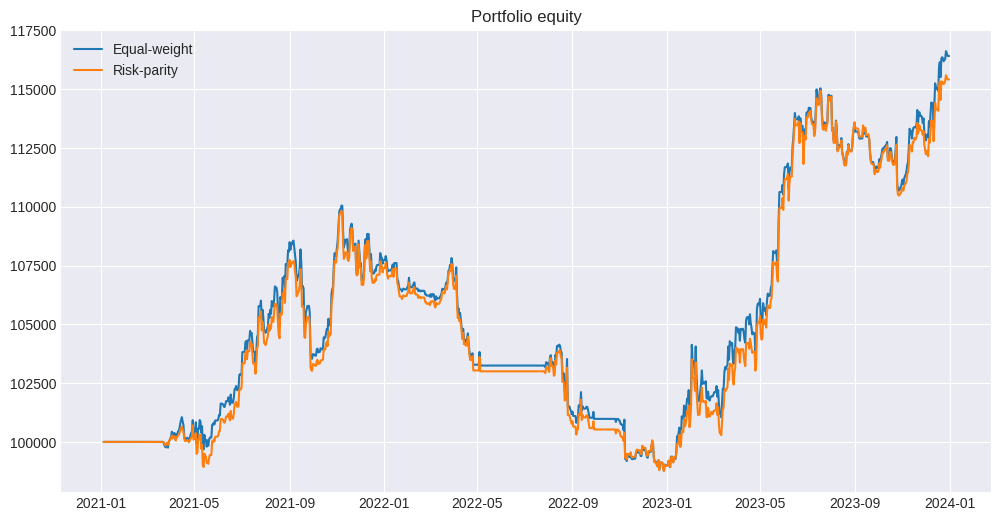

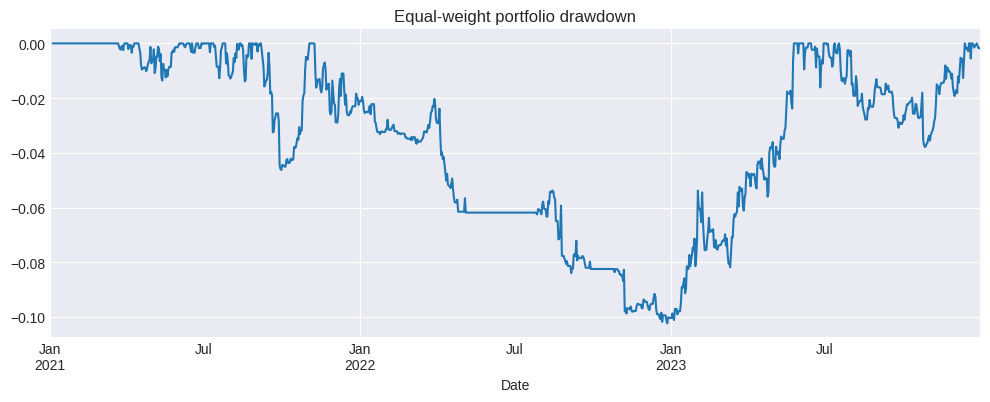

In [51]:
import numpy as np
import pandas as pd
import yfinance as yf
import itertools
import matplotlib.pyplot as plt

# --------------------------
# Data normalization utility
# --------------------------
def normalize_ohlc(df, ticker):
    """
    Normalize yfinance output to flat OHLCV columns for a single ticker.
    Handles both flat and MultiIndex column formats.
    """
    if isinstance(df.columns, pd.MultiIndex):
        # If second level is tickers, select this ticker and flatten first level
        if df.columns.nlevels == 2 and ticker in df.columns.get_level_values(1):
            sub = df.xs(ticker, level=1, axis=1).copy()
            sub.columns = [str(c) for c in sub.columns]
            return sub
        else:
            flat = df.copy()
            flat.columns = flat.columns.get_level_values(0)
            return flat
    else:
        return df

# --------------------------
# Pure pandas/numpy Ichimoku
# --------------------------
def ichimoku(df):
    """
    Compute Ichimoku components using rolling windows (no TA-Lib dependency).
    SSA/SSB are shifted forward by 26, Chikou is lagging by 26.
    """
    high = df["High"]
    low = df["Low"]
    close = df["Close"]

    tenkan = (high.rolling(9).max() + low.rolling(9).min()) / 2
    kijun  = (high.rolling(26).max() + low.rolling(26).min()) / 2
    ssa    = ((tenkan + kijun) / 2).shift(26)
    ssb    = ((high.rolling(52).max() + low.rolling(52).min()) / 2).shift(26)
    chikou = close.shift(-26)

    out = pd.DataFrame(index=df.index)
    out["Tenkan"] = tenkan
    out["Kijun"]  = kijun
    out["SSA"]    = ssa
    out["SSB"]    = ssb
    out["Chikou"] = chikou
    return out

# --------------------------
# Fibonacci levels
# --------------------------
def fib_levels(lookback):
    """
    Compute Fib retracement levels from a lookback window.
    """
    hi = float(lookback["High"].max())
    lo = float(lookback["Low"].min())
    diff = hi - lo
    return {
        "High": hi,
        "Low": lo,
        "0.236": hi - 0.236 * diff,
        "0.382": hi - 0.382 * diff,
        "0.5":   hi - 0.5   * diff,
        "0.618": hi - 0.618 * diff
    }

# --------------------------
# Regime from cloud
# --------------------------
def regime_from_cloud(close, ssa, ssb):
    """
    Determine regime based on price relative to cloud.
    """
    if np.isnan(ssa) or np.isnan(ssb):
        return "Neutral", np.nan, np.nan
    top = max(ssa, ssb)
    bot = min(ssa, ssb)
    if close > top:
        return "Bullish", top, bot
    elif close < bot:
        return "Bearish", top, bot
    else:
        return "Neutral", top, bot

# --------------------------
# Performance metrics
# --------------------------
def performance_metrics(equity_curve):
    """
    Compute TotalReturn, CAGR, Sharpe, Sortino, MaxDrawdown, VaR_95, CVaR_95, Volatility.
    Equity curve should be in dollars; returns use daily pct change.
    """
    equity_curve = equity_curve.dropna()
    if equity_curve.empty:
        return {k:0.0 for k in ["TotalReturn","CAGR","Sharpe","Sortino","MaxDrawdown","VaR_95","CVaR_95","Volatility"]}

    returns = equity_curve.pct_change().dropna()
    ann = 252

    total_return = float(equity_curve.iloc[-1] / equity_curve.iloc[0] - 1)
    years = len(equity_curve) / ann
    cagr = (1 + total_return) ** (1 / years) - 1 if years > 0 and equity_curve.iloc[0] > 0 else 0.0

    vol = float(returns.std() * np.sqrt(ann))
    sharpe = float((returns.mean() * ann) / vol) if vol > 0 else 0.0
    downside = returns[returns < 0]
    ddev = float(downside.std() * np.sqrt(ann)) if not downside.empty else 0.0
    sortino = float((returns.mean() * ann) / ddev) if ddev > 0 else 0.0

    peak = equity_curve.cummax()
    dd = equity_curve / peak - 1
    max_dd = float(max(dd.min(), -1.0))

    alpha = 0.95
    var_95 = float(np.quantile(returns, 1 - alpha)) if not returns.empty else 0.0
    cvar_95 = float(returns[returns <= var_95].mean()) if not returns.empty and (returns <= var_95).any() else var_95

    return {
        "TotalReturn": total_return,
        "CAGR": cagr,
        "Sharpe": sharpe,
        "Sortino": sortino,
        "MaxDrawdown": max_dd,
        "VaR_95": var_95,
        "CVaR_95": cvar_95,
        "Volatility": vol
    }



def backtest_asset(
    ticker,
    # Walk-forward ranges
    train_start=None, train_end=None,
    test_start=None, test_end=None,
    # Entry/exit parameters
    fib_entry="0.382",
    fib_exit="0.236",
    stop_mult=1.5,
    holding_days=20,
    # Sizing and costs
    vol_target=0.15,
    vol_lookback=20,
    slippage=0.001,
    fee=0.0005,
    # Hedge overlay parameters
    hedge_spy=False,            # turn SPY hedge on/off
    hedge_window=60,            # rolling beta window (days)
    hedge_slippage=0.0002,      # optional slippage for hedge leg
    hedge_fee=0.00005,          # optional fee for hedge leg
    # Download options
    period_years=7,
    interval="1d"
):
    # --- Download data ---
    df = yf.download(
        ticker,
        period=f"{period_years}y",
        interval=interval,
        progress=False,
        auto_adjust=False,
        group_by='column'
    )
    if df is None or df.empty:
        return pd.DataFrame(), pd.Series(dtype=float), {}

    # Normalize OHLC
    def _normalize_ohlc(df_in, tk):
        if isinstance(df_in.columns, pd.MultiIndex):
            try:
                sub = df_in.xs(tk, level=1, axis=1).copy()
                sub.columns = [str(c) for c in sub.columns]
                return sub
            except Exception:
                flat = df_in.copy()
                flat.columns = flat.columns.get_level_values(0)
                return flat
        return df_in

    df = _normalize_ohlc(df, ticker).dropna()
    need = {"Open","High","Low","Close"}
    if not need.issubset(set(df.columns)):
        return pd.DataFrame(), pd.Series(dtype=float), {}

    for c in ["Open","High","Low","Close","Volume"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    df = df.dropna()

    # --- Indicators (Ichimoku) ---
    def ichimoku(df_in):
        high, low, close = df_in["High"], df_in["Low"], df_in["Close"]
        tenkan = (high.rolling(9).max() + low.rolling(9).min()) / 2
        kijun  = (high.rolling(26).max() + low.rolling(26).min()) / 2
        ssa    = ((tenkan + kijun) / 2).shift(26)
        ssb    = ((high.rolling(52).max() + low.rolling(52).min()) / 2).shift(26)
        chikou = close.shift(-26)
        return pd.DataFrame({"Tenkan":tenkan,"Kijun":kijun,"SSA":ssa,"SSB":ssb,"Chikou":chikou})

    ichi = ichimoku(df)
    df = pd.concat([df, ichi], axis=1)

    # Restrict to test window if provided
    if test_start and test_end:
        df = df.loc[(df.index >= pd.to_datetime(test_start)) & (df.index <= pd.to_datetime(test_end))]
    if df.empty or len(df) < 150:  # warmup for Ichimoku
        return pd.DataFrame(), pd.Series(dtype=float), {}

    # --- Helpers ---
    def fib_levels(lookback):
        hi = float(lookback["High"].max())
        lo = float(lookback["Low"].min())
        diff = hi - lo
        return {
            "High": hi, "Low": lo,
            "0.236": hi - 0.236 * diff,
            "0.382": hi - 0.382 * diff,
            "0.5":   hi - 0.5   * diff,
            "0.618": hi - 0.618 * diff
        }

    def regime_from_cloud(close, ssa, ssb):
        if np.isnan(ssa) or np.isnan(ssb):
            return "Neutral", np.nan, np.nan
        top, bot = max(ssa, ssb), min(ssa, ssb)
        if close > top: return "Bullish", top, bot
        if close < bot: return "Bearish", top, bot
        return "Neutral", top, bot

    def performance_metrics(equity_curve):
        equity_curve = equity_curve.dropna()
        if equity_curve.empty:
            return {k:0.0 for k in ["TotalReturn","CAGR","Sharpe","Sortino","MaxDrawdown","VaR_95","CVaR_95","Volatility"]}
        returns = equity_curve.pct_change().dropna()
        ann = 252
        total_return = float(equity_curve.iloc[-1] / equity_curve.iloc[0] - 1)
        years = len(equity_curve) / ann
        cagr = (1 + total_return) ** (1 / years) - 1 if years > 0 and equity_curve.iloc[0] > 0 else 0.0
        vol = float(returns.std() * np.sqrt(ann))
        sharpe = float((returns.mean() * ann) / vol) if vol > 0 else 0.0
        downside = returns[returns < 0]
        ddev = float(downside.std() * np.sqrt(ann)) if not downside.empty else 0.0
        sortino = float((returns.mean() * ann) / ddev) if ddev > 0 else 0.0
        peak = equity_curve.cummax()
        dd = equity_curve / peak - 1
        max_dd = float(max(dd.min(), -1.0))
        alpha = 0.95
        var_95 = float(np.quantile(returns, 1 - alpha)) if not returns.empty else 0.0
        cvar_95 = float(returns[returns <= var_95].mean()) if not returns.empty and (returns <= var_95).any() else var_95
        return {"TotalReturn": total_return, "CAGR": cagr, "Sharpe": sharpe, "Sortino": sortino,
                "MaxDrawdown": max_dd, "VaR_95": var_95, "CVaR_95": cvar_95, "Volatility": vol}

    # --- State ---
    initial_capital = 100_000.0
    cash = initial_capital
    equity = pd.Series(index=df.index, dtype=float)
    equity.iloc[0] = initial_capital

    position_units = 0.0
    entry_px = None
    trade = None
    trades = []

    # Vol targeting (annualized)
    daily_vol = df["Close"].pct_change().rolling(vol_lookback).std() * np.sqrt(252)

    lookback_len = 60  # Fib window
    start_i = max(lookback_len, 80)

    # --- Main loop (signals on bar i, execution on bar i+1) ---
    for i in range(start_i, len(df) - 1):
        ts = df.index[i]
        lookback = df.iloc[i - lookback_len:i]
        fib = fib_levels(lookback)
        ssa = df["SSA"].iloc[i]
        ssb = df["SSB"].iloc[i]
        close_i = float(df["Close"].iloc[i])

        regime, cloud_top, cloud_bot = regime_from_cloud(close_i, ssa, ssb)
        if np.isnan(ssa) or np.isnan(ssb):
            equity.iloc[i] = equity.iloc[i-1]
            continue

        # Entry (long-only example)
        if position_units == 0.0:
            if regime == "Bullish" and close_i > fib.get(fib_entry, np.nan):
                next_close = float(df["Close"].iloc[i+1])
                raw_entry = next_close
                entry_px = raw_entry * (1 + slippage + fee)

                vol_i = float(daily_vol.iloc[i]) if not np.isnan(daily_vol.iloc[i]) else np.nan
                if np.isnan(vol_i) or vol_i <= 0:
                    equity.iloc[i] = equity.iloc[i-1]
                    continue

                weight = min(vol_target / vol_i, 1.0)  # cap leverage at 1x
                notional = cash * weight
                position_units = notional / entry_px

                rng = fib["High"] - fib["Low"]
                stop_px = max(1e-8, fib["Low"] - stop_mult * rng)

                trade = {
                    "Ticker": ticker, "Side": "Long",
                    "EntryTime": df.index[i+1], "EntryIndex": i+1,
                    "EntryPriceRaw": raw_entry, "EntryPrice": entry_px,
                    "SizeUnits": position_units, "SizeNotional": notional,
                    "StopPrice": stop_px, "CloudTop": cloud_top, "CloudBot": cloud_bot,
                    "Fib_382": fib["0.382"], "Fib_618": fib["0.618"], "Fib_236": fib["0.236"], "Fib_500": fib["0.5"],
                    "SwingHigh": fib["High"], "SwingLow": fib["Low"], "HoldingDaysTarget": holding_days,
                    "Slippage": slippage, "Fee": fee, "VolTarget": vol_target
                }

        # Exit
        else:
            time_held = (i - trade["EntryIndex"])
            exit_signal = (
                regime != "Bullish" or
                close_i < fib.get(fib_exit, np.nan) or
                time_held >= holding_days or
                close_i <= trade["StopPrice"]
            )
            if exit_signal:
                next_close = float(df["Close"].iloc[i+1])
                raw_exit = next_close
                exit_px = raw_exit * (1 - slippage - fee)

                pnl = (exit_px - trade["EntryPrice"]) * position_units
                cash += pnl

                trades.append({
                    **trade,
                    "ExitTime": df.index[i+1], "ExitIndex": i+1,
                    "ExitPriceRaw": raw_exit, "ExitPrice": exit_px,
                    "HoldingDays": time_held,
                    "TradeReturnPct": (exit_px / trade["EntryPrice"] - 1.0) * 100.0,
                    "PnL": pnl, "CashAfter": cash
                })

                position_units = 0.0
                trade = None
                entry_px = None

        # Mark-to-market (unhedged equity for now)
        if position_units == 0.0:
            equity.iloc[i] = cash
        else:
            mtm = (close_i / entry_px - 1.0)
            equity.iloc[i] = cash + mtm * position_units * entry_px

    # Finalize unhedged equity
    equity = equity.ffill().dropna()

    # --- Optional SPY hedge overlay ---
    if hedge_spy:
        # Download SPY and compute daily returns over the same date range
        spy_df = yf.download("SPY", period=f"{period_years}y", interval=interval, progress=False, auto_adjust=False)
        spy_close = spy_df["Close"].astype(float).dropna()
        spy_ret = spy_close.pct_change()

        # Align returns
        strat_ret = equity.pct_change()
        aligned = pd.concat([strat_ret, spy_ret], axis=1).dropna()
        aligned.columns = ["StratRet", "SPYRet"]

        # Rolling beta (no look-ahead -> shift 1 day)
        beta = aligned["StratRet"].rolling(hedge_window).cov(aligned["SPYRet"]) / aligned["SPYRet"].rolling(hedge_window).var()
        beta = beta.shift(1).reindex(equity.index).fillna(0.0)

        # Hedge notional = beta * equity value; hedge PnL = - hedge_notional(prev day) * SPY_ret(today)
        spy_ret_aligned = spy_ret.reindex(equity.index).fillna(0.0)
        hedge_notional = beta * equity
        # Apply hedge costs by reducing effective SPY return
        hedge_cost_adj = max(0.0, 1.0 - (hedge_slippage + hedge_fee))
        effective_spy_ret = spy_ret_aligned * hedge_cost_adj

        hedge_pnl = -hedge_notional.shift(1).fillna(0.0) * effective_spy_ret
        hedge_cum = hedge_pnl.cumsum()

        equity_hedged = (equity - hedge_cum).dropna()
        metrics_hedged = performance_metrics(equity_hedged)

        # Replace outputs with hedged equity while preserving trade log
        metrics_unhedged = performance_metrics(equity)
        # You may want to return both; here we bundle them
        metrics = {"Unhedged": metrics_unhedged, "Hedged_SPY": metrics_hedged}
        trade_log = pd.DataFrame(trades)
        return trade_log, equity_hedged, metrics

    # Unhedged outputs
    metrics = performance_metrics(equity)
    trade_log = pd.DataFrame(trades)
    return trade_log, equity, metrics


def run_walkforward_grid(
    tickers,
    train_test_windows,  # list of dicts: {"train_start":..., "train_end":..., "test_start":..., "test_end":...}
    fib_entries = ["0.382","0.5","0.618"],
    fib_exits   = ["0.236","0.382","0.5"],
    stop_mults  = [1.0, 1.5, 2.0],
    holding_days_list = [10, 20, 30],
    vol_targets = [0.10, 0.15, 0.20],
    slippages   = [0.0005, 0.001, 0.002],
    fees        = [0.0001, 0.0005, 0.001],
    period_years = 7,
    interval="1d"
):
    """
    Runs parameter grid across walk-forward windows for each ticker.
    Returns a dataframe leaderboard of results.
    """
    results = []

    for w in train_test_windows:
        for fib_entry, fib_exit, stop_mult, hold, vol_tgt, slip, fee in itertools.product(
            fib_entries, fib_exits, stop_mults, holding_days_list, vol_targets, slippages, fees
        ):
            for t in tickers:
                tl, eq, met = backtest_asset(
                    t,
                    train_start=w.get("train_start"), train_end=w.get("train_end"),
                    test_start=w.get("test_start"),  test_end=w.get("test_end"),
                    fib_entry=fib_entry, fib_exit=fib_exit,
                    stop_mult=stop_mult, holding_days=hold,
                    vol_target=vol_tgt, slippage=slip, fee=fee,
                    period_years=period_years, interval=interval
                )
                results.append({
                    "Ticker": t,
                    "Window": f'{w.get("test_start")}–{w.get("test_end")}',
                    "FibEntry": fib_entry,
                    "FibExit": fib_exit,
                    "StopMult": stop_mult,
                    "HoldingDays": hold,
                    "VolTarget": vol_tgt,
                    "Slippage": slip,
                    "Fee": fee,
                    **met
                })
    return pd.DataFrame(results)

def construct_portfolio(asset_equities, method="equal"):
    """
    Build portfolio equity from per-asset equity curves.
    method: "equal" or "risk-parity"
    """
    aligned = pd.concat(asset_equities.values(), axis=1).ffill().dropna(how="all")
    aligned.columns = list(asset_equities.keys())
    aligned = aligned.dropna(axis=1, how="all")
    if aligned.empty:
        return pd.Series(dtype=float)

    if method == "equal":
        weights = {t: 1.0/len(aligned.columns) for t in aligned.columns}
    elif method == "risk-parity":
        vols = aligned.pct_change().rolling(60).std().iloc[-1]
        inv_vol = 1.0 / vols.replace(0, np.nan)
        inv_vol = inv_vol / inv_vol.sum()
        weights = inv_vol.to_dict()
    else:
        raise ValueError("Unknown method")

    port = pd.Series(0.0, index=aligned.index)
    for t in aligned.columns:
        port += weights.get(t, 0.0) * aligned[t]
    return port


# Assets and walk-forward windows
ASSETS = ["BTC-USD","ETH-USD","AAPL","MSFT","AMZN","NVDA","GOOGL","GOOG","META","TSLA","BRK-B","AVGO"]
WF_WINDOWS = [
    {"train_start":"2016-01-01","train_end":"2019-12-31","test_start":"2020-01-01","test_end":"2020-12-31"},
    {"train_start":"2017-01-01","train_end":"2020-12-31","test_start":"2021-01-01","test_end":"2021-12-31"},
    {"train_start":"2018-01-01","train_end":"2021-12-31","test_start":"2022-01-01","test_end":"2022-12-31"},
]

# Run grid search + walk-forward (this can take time; adjust grids for speed)
grid_results = run_walkforward_grid(
    ASSETS,
    WF_WINDOWS,
    fib_entries=["0.382","0.5","0.618"],
    fib_exits=["0.236","0.382"],
    stop_mults=[1.0, 1.5],
    holding_days_list=[10, 20],
    vol_targets=[0.10, 0.15],
    slippages=[0.0005, 0.001],
    fees=[0.0001, 0.0005],
    period_years=7,
    interval="1d"
)

# Leaderboard
leaderboard = grid_results.sort_values(["Sharpe","CAGR"], ascending=[False, False]).head(20)
print(leaderboard[["Ticker","Window","FibEntry","FibExit","StopMult","HoldingDays","VolTarget","Slippage","Fee","Sharpe","CAGR","MaxDrawdown","TotalReturn"]])

# Final backtests for portfolio build with chosen params
asset_equities = {}
for t in ASSETS:
    tl, eq, met = backtest_asset(
        t,
        test_start="2021-01-01", test_end="2023-12-31",
        fib_entry="0.5", fib_exit="0.382",
        stop_mult=1.5, holding_days=20,
        vol_target=0.15, slippage=0.001, fee=0.0005,
        period_years=7, interval="1d"
    )
    asset_equities[t] = eq
    print(f"{t} metrics:", met)

# Portfolios
portfolio_equal = construct_portfolio(asset_equities, method="equal")
portfolio_rp    = construct_portfolio(asset_equities, method="risk-parity")

print("Equal-weight portfolio metrics:", performance_metrics(portfolio_equal))
print("Risk-parity portfolio metrics:", performance_metrics(portfolio_rp))

# Visualize equity curves
plt.figure(figsize=(12,6))
plt.plot(portfolio_equal.index, portfolio_equal.values, label="Equal-weight")
plt.plot(portfolio_rp.index, portfolio_rp.values, label="Risk-parity")
plt.title("Portfolio equity")
plt.legend()
plt.show()

# Visualize drawdown for equal-weight
dd = portfolio_equal / portfolio_equal.cummax() - 1
dd.plot(title="Equal-weight portfolio drawdown", figsize=(12,4))
plt.show()
